In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline
from statannot import add_stat_annotation

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
flierprops = dict(markerfacecolor='lightgrey',markeredgecolor='lightgrey')

In [3]:
import sys
sys.path.append('../utils/')
from stat_annot_utils import create_pairs, create_hue_pairs, parse_results_from_statannot
from plot_medians_in_boxplot import plot_medians_in_boxplot
from cliffs_d import calc_boxplot_effect_size
from stat_annot_utils import create_pairs

In [4]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

### TMB boxplots

In [5]:
tmb_df = pd.read_csv('../data/moores_predict/tmb.tsv', sep='\t')
print(tmb_df.shape)
tmb_df.head(2)

(83, 9)


,tmb_unfiltered,tmb_filtered,Gender,Age (at treatment with immunotherapy),OS from the start of IO (months),"Dead (yes =1, no =0)",PFS (startdate to PD),Progression = 1,response
0,2,2.0,Female,44.2,6.3,0,1.1,1,nonresponse
1,3,1.0,Female,72.5,0.5,1,0.5,1,nonresponse


tmb_filtered Effect size: SD/response r=0.439
tmb_filtered Effect size: nonresponse/response r=0.336
tmb_filtered Effect size: SD/nonresponse r=0.179


tmb_unfiltered Effect size: SD/response r=0.384
tmb_unfiltered Effect size: nonresponse/response r=0.442
tmb_unfiltered Effect size: SD/nonresponse r=0.106


../data/publication_figures/Fig5.TMB_filtered_vs_response.pdf


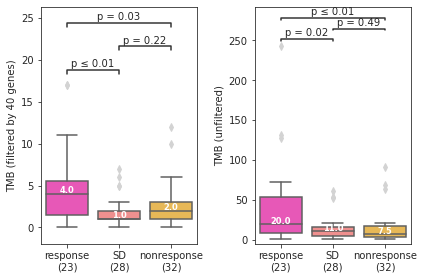

In [6]:
x = 'response'
tmb_df[x] = tmb_df[x].apply(str)
order = ['response','SD','nonresponse']
ylim_dict = {'tmb_filtered': (-2,21), 'tmb_unfiltered': (-5,105)}

plt.figure(figsize=(6,4))
i=1
for y in ['tmb_filtered','tmb_unfiltered']:
    plt.subplot(1,2,i)

    bp = sns.boxplot(x=x, y=y, data=tmb_df, order=order, palette='spring', flierprops=flierprops)
    plt.ylim(ylim_dict[y])

    stat_res = add_stat_annotation(ax=bp, x=x, y=y, box_pairs=create_pairs(order), order=order, 
                            test='Mann-Whitney',comparisons_correction=None, text_format='simple',
                            data=tmb_df, loc='inside', verbose=False)
    
    # effect sizes
    stat_res = parse_results_from_statannot(stat_res)
    for pair in create_pairs(order):
        pair = sorted(pair)
        U = stat_res[tuple(pair)][0]
        e = calc_boxplot_effect_size(len(tmb_df[tmb_df[x]==pair[0]]), len(tmb_df[tmb_df[x]==pair[1]]), U)
    
        print(y, 'Effect size: {} r={:.3}'.format('/'.join(pair), e))

    # plot medians and number of samples info
    medians = tmb_df.groupby([x])[y].median()
    plot_medians_in_boxplot(medians, vertical_offset=0.1, ax=bp)
    
    counts = tmb_df[x].value_counts()
    bp.set_xticklabels(['{}\n({})'.format(x.get_text(), counts.loc[x.get_text()]) for x in bp.get_xticklabels()])
    
    plt.xlabel('')
    plt.ylabel('TMB (filtered by 40 genes)') if y=='tmb_filtered' else plt.ylabel('TMB (unfiltered)')
    
    i+=1
    print('\n')
    
plt.tight_layout()
savepath = '../data/publication_figures/Fig5.TMB_filtered_vs_response.pdf'
print(savepath)
plt.savefig(savepath)
plt.show()

## PHBR KM analysis

In [7]:
unfiltered_phbr_df = pd.read_csv('../data/moores_predict/unfiltered_phbr.tsv', sep='\t')
print(unfiltered_phbr_df.shape)

filtered_phbr_df = pd.read_csv('../data/moores_predict/filtered_phbr.tsv', sep='\t')
print(filtered_phbr_df.shape)

(71, 8)
(71, 8)


#### Overall

PFS (startdate to PD) Progression = 1


/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


unfiltered ('PHBR-low', 'PHBR-high') 2.513099387547636 0.11290368307874595


/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


filtered ('PHBR-low & immuno-loc', 'PHBR-high & immuno-loc') 3.683455235565588 0.054954855331361366
../data/publication_figures/Fig5.PFS_KM.pdf


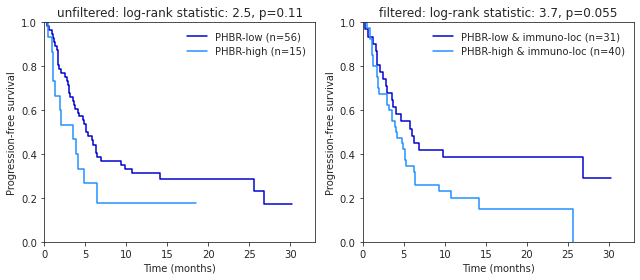

In [8]:
## PHBR only
color_list = [ 'mediumblue','dodgerblue','seagreen','red']

for duration, event in [('PFS (startdate to PD)','Progression = 1' )]:
    print(duration, event)
    
    plt.figure(figsize=(9,4))
    i = 1
    for t, df in [('unfiltered', unfiltered_phbr_df),('filtered', filtered_phbr_df), ]:
        groups = df['cat']
        
        for c_i, g in enumerate(df['cat'].unique()):
            ix = (groups == g)

            plt.subplot(1,2,i)
            kmf = KaplanMeierFitter()
            kmf.fit(df[duration][ix], df[event][ix], label='{} (n={})'.format(g, len(df[ix])))
            ax = kmf.plot_survival_function(ci_show=False, color=color_list[c_i])
            plt.title(t)
            
        plt.ylabel('Progression-free survival'), plt.xlabel('Time (months)')
        plt.ylim(0,1),plt.xlim(0,33)
        plt.legend(frameon=False)
        
        for pair in create_pairs(groups.unique()):

            a = (groups == pair[0])
            b = (groups == pair[1])

            pval= logrank_test(df[duration][a], df[duration][b], df[event][a], df[event][b], )
            print(t, pair, pval.test_statistic, pval.p_value)

            plt.title('{}: log-rank statistic: {:.2}, p={:.2}'.format(t,pval.test_statistic, pval.p_value))

        i+=1
    plt.tight_layout()
    savepath = '../data/publication_figures/Fig5.PFS_KM.pdf'
    print(savepath)
    plt.savefig(savepath)
    plt.show()

#### in high tmb patients

PFS (startdate to PD) Progression = 1


/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


unfiltered ('PHBR-low', 'PHBR-high') 5.578999792245904e-05 0.9940404400088343


/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


filtered ('PHBR-low & immuno-loc', 'PHBR-high & immuno-loc') 2.1377457344226727 0.1437129350816506


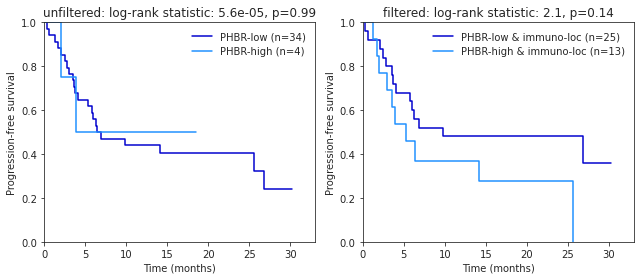

In [9]:
## PHBR only
color_list = [ 'mediumblue','dodgerblue','seagreen','red']

for duration, event in [('PFS (startdate to PD)','Progression = 1' )]:
    print(duration, event)
    
    plt.figure(figsize=(9,4))
    i = 1
    for t, df in [('unfiltered', unfiltered_phbr_df),('filtered', filtered_phbr_df), ]:
        df = df[df['TMB_binary_10']=='TMB high']
        groups = df['cat']
        
        
        for c_i, g in enumerate(df['cat'].unique()):
            ix = (groups == g)

            plt.subplot(1,2,i)
            kmf = KaplanMeierFitter()
            kmf.fit(df[duration][ix], df[event][ix], label='{} (n={})'.format(g, len(df[ix])))
            ax = kmf.plot_survival_function(ci_show=False, color=color_list[c_i])
            plt.title(t)
            
        plt.ylabel('Progression-free survival'), plt.xlabel('Time (months)')
        plt.ylim(0,1),plt.xlim(0,33)
        plt.legend(frameon=False)
        
        for pair in create_pairs(groups.unique()):

            a = (groups == pair[0])
            b = (groups == pair[1])

            pval= logrank_test(df[duration][a], df[duration][b], df[event][a], df[event][b], )
            print(t, pair, pval.test_statistic, pval.p_value)

            plt.title('{}: log-rank statistic: {:.2}, p={:.2}'.format(t,pval.test_statistic, pval.p_value))

        i+=1
    plt.tight_layout()
    plt.show()

In [10]:
model_cols = ['PHBR_score','TMB (mutations per megabase)', 
              'Age (at treatment with immunotherapy)','Gender']
event, duration = 'Progression = 1', 'PFS (startdate to PD)'

cox_df = pd.DataFrame()
for t, model_df in [('unfiltered', unfiltered_phbr_df), ('filtered',filtered_phbr_df)]:
    print(t)

    model_df = model_df[model_df['TMB_binary_10']=='TMB high']
    model_df = model_df[model_cols+[event,duration]]

    model_df['Gender'] = model_df['Gender'].replace({'Female':1, 'Male':0})
    print(model_df.shape)
    model_df = model_df.dropna()
    print(model_df.shape)

    cph = CoxPHFitter()
    cph.fit(model_df, duration_col=duration, event_col=event)
    res = cph.summary[['exp(coef)','se(coef)','p']]
    print('AIC:',cph.AIC_partial_,'\n')
    cox_df = res if len(cox_df)==0 else cox_df.join(res, lsuffix='_{}'.format(t), rsuffix='_{}'.format(t))
cox_df

unfiltered
(38, 6)
(38, 6)
AIC: 151.72382394021926 

filtered
(38, 6)
(38, 6)
AIC: 147.86709574330814 



,exp(coef)_filtered,se(coef)_filtered,p_filtered,exp(coef)_filtered,se(coef)_filtered,p_filtered
covariate,,,,,,
PHBR_score,1.359205,0.224658,0.171915,1.273309,0.093965,0.010129
TMB (mutations per megabase),0.997227,0.003796,0.464532,0.997931,0.003657,0.571154
Age (at treatment with immunotherapy),0.984012,0.016682,0.333970,0.974767,0.017122,0.135535
Gender,1.880660,0.456175,0.166173,1.555139,0.475311,0.352887
